In [1]:
from comet_ml import Experiment
from comet_ml import OfflineExperiment
import pandas as pd 
from cfg import *
import cv2
import numpy as np
from loader import data_pipe
from skimage.feature import texture
import glob
from personal_cls import run
import lightgbm as lgb
import random

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_validate
from loader import numerical_loader
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from cfg import *
import random
import matplotlib.pyplot as plt
import shap

from loader import *
from mri_cls import clf as img_clf
from personal_cls import clf as num_clf

In [2]:
vis = True
X_num, y = numerical_loader(drop_name=not vis)
X_num = pd.DataFrame(X_num)
X_num['label'] = y
X_num[0] = X_num[0].astype(str)
X_num = X_num.rename(columns={0: 'fname'})

Index(['病歷號 (yellow in WHO grade I file) ', 'Gender (M:1 F:0)', 'Age',
       'ADC tumor', 'Adjacent bone invasion', 'GTR', 'STR',
       'Peritumoral edema (Yes:1 or No:1)',
       'Heterogeneous enhancement (Yes:1 or No:0)', 'Calcification',
       'Reactive hyperostosis', 'Dural tail sign', 'Cystic change or necrosis',
       'Maximal diameter', 'Tumor volume (cm3)', 'x', 'y', 'z',
       'Special histology_0', 'Special histology_1', 'Special histology_3',
       'Simpson grade resection_1', 'Simpson grade resection_2',
       'Simpson grade resection_3', 'Simpson grade resection_4'],
      dtype='object')
(25,) (25,)
Number of Patients and feature : 57 17
Number of Case 1 and Case 2 : 44 13
-------------------------
Using feature:
0 | 病歷號 (yellow in WHO grade I file) 
1 | Gender (M:1 F:0)
2 | ADC tumor
3 | GTR
4 | STR
5 | Peritumoral edema (Yes:1 or No:1)
6 | Heterogeneous enhancement (Yes:1 or No:0)
7 | Calcification
8 | Dural tail sign
9 | Maximal diameter
10 | Tumor volume (cm3)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 17 but corresponding boolean dimension is 15

In [ ]:
dtype = ['T1', 'T1c', 'T2', 'Flair']
# dtype = ['Flair']
X_img, y = img_features(dtype, return_df=True)
X_img['fname'] =  X_img['fname'].apply(lambda raw:raw.split('/')[-1][:-4]+'.0')

In [ ]:
X_ALL = pd.merge(X_num, X_img, how='inner', on='fname')
X_fname = X_ALL.pop('fname')

def run(X, cls, ros=False, thr=.5, seed=None, vis=True):
    met =  ['accuracy', 'precision', 'recall', 'roc_auc', 'fpr', 'tpr']
    metric = ['train_' + val for val in met] + ['test_' + val for val in met]
    result = {}
    for m in metric:result[m] = []

    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=seed)
    
    y = X.pop('label')
    svm_scores = pd.DataFrame(X_fname.copy())
    svm_scores['prob'] = ""
    
    for train_idx, val_idx in skf.split(X, y):
        Xnum_train, Xnum_test = X.loc[train_idx], X.loc[val_idx]
        y_train, y_test = y.loc[train_idx], y.loc[val_idx]

        Ximg_train = Xnum_train.pop('img_feature').to_list()
        Ximg_test = Xnum_test.pop('img_feature').to_list()
        
        Ximg_train = np.array(Ximg_train)
        Ximg_test = np.array(Ximg_test)

        if ros:  Ximg_for_train, y_for_train = SMOTE(random_state=42).fit_resample(Ximg_train, y_train)

        pos = 1
        img_clf.fit(Ximg_for_train, y_for_train)
        img_probs_train = img_clf.decision_function(Ximg_train)
        img_probs_test = img_clf.decision_function(Ximg_test)
        img_probs_train = np.expand_dims(img_probs_train, 1)
        img_probs_test = np.expand_dims(img_probs_test, 1)

        num_clf.fit(Xnum_train, y_train)
        num_probs_train = num_clf.predict_proba(Xnum_train)[:, pos:]
        num_probs_test = num_clf.predict_proba(Xnum_test)[:, pos:]
        explainer = shap.TreeExplainer(num_clf)
        shap_values_num = explainer.shap_values(Xnum_test)

        probs_train = np.concatenate([img_probs_train, num_probs_train], axis=1)
        probs_test = np.concatenate([img_probs_test, num_probs_test], axis=1)
        
        cls.fit(probs_train, y_train)
        # Model importance
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(probs_test)
        y_pred = cls.predict_proba(probs_test)
        
        # svm_scores['prob'].loc[val_idx] = y_pred[:, 0]
        svm_scores['prob'].loc[val_idx] = y_pred[:, 1]

        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred[:, 1])
        y_pred = [1 if logit>thr else 0 for logit in y_pred[:, 1]]

        result['test_accuracy'].append(metrics.accuracy_score(y_test, y_pred, ),)
        result['test_precision'].append(metrics.precision_score(y_test, y_pred, zero_division=1),)
        result['test_recall'].append(metrics.recall_score(y_test, y_pred, zero_division=1),)
        result['test_roc_auc'].append(metrics.roc_auc_score(y_test, y_pred),)
        result['test_fpr'].append(fpr)
        result['test_tpr'].append(tpr)
    # svm_scores['n'] = svm_scores2
    if vis:
        return result, svm_scores, shap_values, probs_test, shap_values_num, Xnum_test
    return result, svm_scores

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplain

accuracy |	 0.8575757575757577
precision |	 0.8666666666666666
recall |	 0.5333333333333333
roc_auc |	 0.7444444444444445


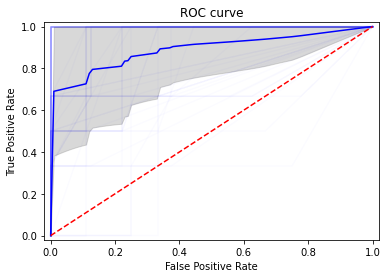

In [ ]:
experiment = Experiment(
        api_key=COMET_APT_KEY,
        project_name=COMET_PROJECT_NAME,
        workspace=COMET_WORK_SPACE,
        display_summary_level=0,
        log_code=False,
        disabled=True, 
)
experiment.add_tag('ensemble')
met =  ['accuracy', 'precision', 'recall', 'roc_auc']
metric = ['test_' + val for val in met]
base_fpr = np.linspace(0, 1, 101)
tprs = []
total_result = {}
for m in metric: total_result[m] = []

# clf = LogisticRegression(
#     class_weight='balanced', 
#     max_iter=100,
#     penalty='no
# ne',
# )
clf = RandomForestClassifier(max_depth=3, random_state=0, class_weight='balanced', 
                             n_estimators=11)
svm_scores = []
for i in range(NUM_RANDOM_STATE):
    if vis:
        result, scores, shap_values, shap_X_test, shap_values_num, Xnum_test = run(X_ALL.copy(), clf, thr=.50, seed=SEEDS[i], ros=True)
    else:
        result, scores = run(X_ALL.copy(), clf, thr=.50, seed=SEEDS[i], ros=True)
    for m in metric: total_result[m].append(result[m])
    for j in range(len(result['test_fpr'])):
        plt.plot(result['test_fpr'][j], result['test_tpr'][j], 'b', alpha=0.015)
        tpr = np.interp(base_fpr, result['test_fpr'][j], result['test_tpr'][j])
        tpr[0] = 0.0
        tprs.append(tpr)
    svm_scores.append(scores)
    # break 
        
for m in met: 
    print(m ,'|\t',
        #   np.mean(result[f'train_{m}']),
          np.mean(result[f'test_{m}']))
    experiment.log_metric(m, np.mean(result[f'test_{m}']))
tprs = np.array(tprs)        
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
 
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
experiment.log_curve('ROC_CURVE', base_fpr, mean_tprs)
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
experiment.log_parameters({'seeds':SEEDS})
experiment.log_figure('ROC curve', figure=plt)
experiment.end()
plt.show()
# mean_tprs.tolist()

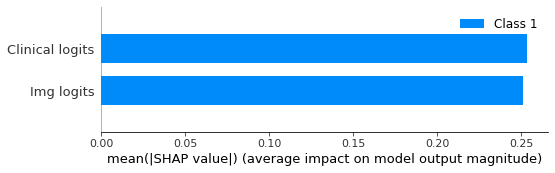

In [ ]:
import shap
shap.summary_plot(shap_values, shap_X_test, plot_type="bar", class_inds=[1], feature_names=['Img logits', 'Clinical logits'])

In [ ]:
# from functools import reduce
# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['fname'], how='outer'), svm_scores)
# fname = df_merged.pop('fname')

# print(df_merged.shape)
# avg_score = df_merged.agg("mean", axis=1)
# avg_score = pd.DataFrame(avg_score)
# avg_score['Patient ID'] = fname.to_list()
# avg_score.to_csv('./svm_socres.csv')

# avg_score.pop('Patient ID')
# avg_score.max(), avg_score.min()
# mean_tprs.tolist()

[array([0.80889493, 0.19110507]),
 array([0.04183308, 0.95816692]),
 array([0., 1.]),
 array([1.00000000e+00, 7.40876102e-16]),
 array([0.15671053, 0.84328947]),
 array([0.05200244, 0.94799756]),
 array([0., 1.]),
 array([1., 0.]),
 array([0.05477373, 0.94522627]),
 array([1.00000000e+00, 2.99157381e-16]),
 array([1., 0.])]

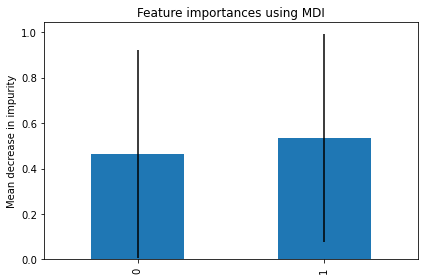

In [ ]:
# Feature importance 

import pandas as pd
import numpy as np

forest = clf
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
[tree.feature_importances_ for tree in forest.estimators_]